In [1]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import torch.utils.data as Data
import matplotlib.pyplot as plt
from D4R_vae import *
from D4R_serial import *
from utils import *
import config

## First, load some data

In [2]:
# path = "../dataset/crystal.lammpstrj"
path = "../dataset/solute.lammpstrj"
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
atom_coords, box_list = read_lammps_file(path, last_frame=10, interval_frame=config.interval_frame,
                                         ratio=config.ratio, return_box_list=True)
atom_coords = torch.tensor(atom_coords, dtype=torch.float).to(device)
atom_types = read_lammps_file_atom_type(path)
atom_types = torch.tensor(atom_types, dtype=torch.int).to(device)

Reading: current step:0/0

In [22]:
filename = 'solute'
feature_inputs = torch.load(f'../temp_data/{filename}/feature_inputs.pt')
targets = torch.load(f'../temp_data/{filename}/targets.pt')
atom_coords = torch.load(f'../temp_data/{filename}/atom_coords.pt')
atom_types = torch.load(f'../temp_data/{filename}/atom_types.pt')
box_list = torch.load(f'../temp_data/{filename}/box_list.pt')
I, J, K = IJK_from_box_list(box_list)

In [4]:
model_path = '../pretrained_model/serial_model_solute.pth'
num_nearest_atoms = config.num_nearest_atoms
num_atoms = atom_coords.shape[1]
parameters = config.parameters
num_features = 3 + len(parameters[1])

## Making the preprocessing

In [5]:
current_frame_coords = atom_coords[0]
feature_input = preprocess_one_frame(current_frame_coords, num_nearest_atoms, num_atoms, num_features, atom_types,
                                             parameters).to(device)

## Load the model and then conduct calculation

In [6]:
# model = torch.load(model_path).to(device)
# displacement = model(feature_input.unsqueeze(0))
# output_coords = current_frame_coords+displacement

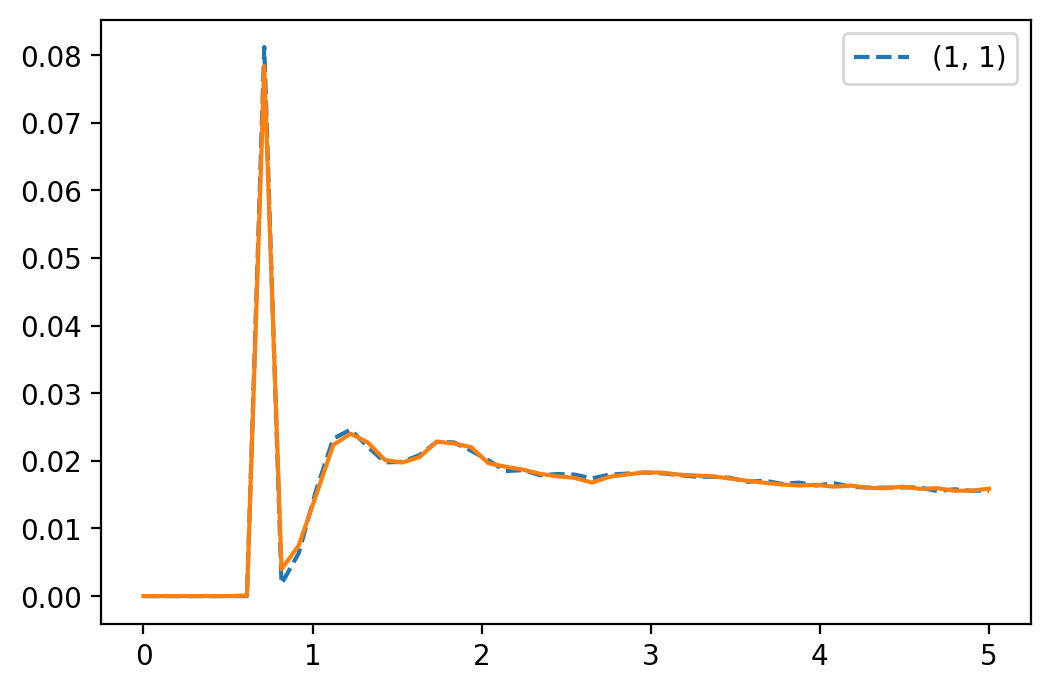

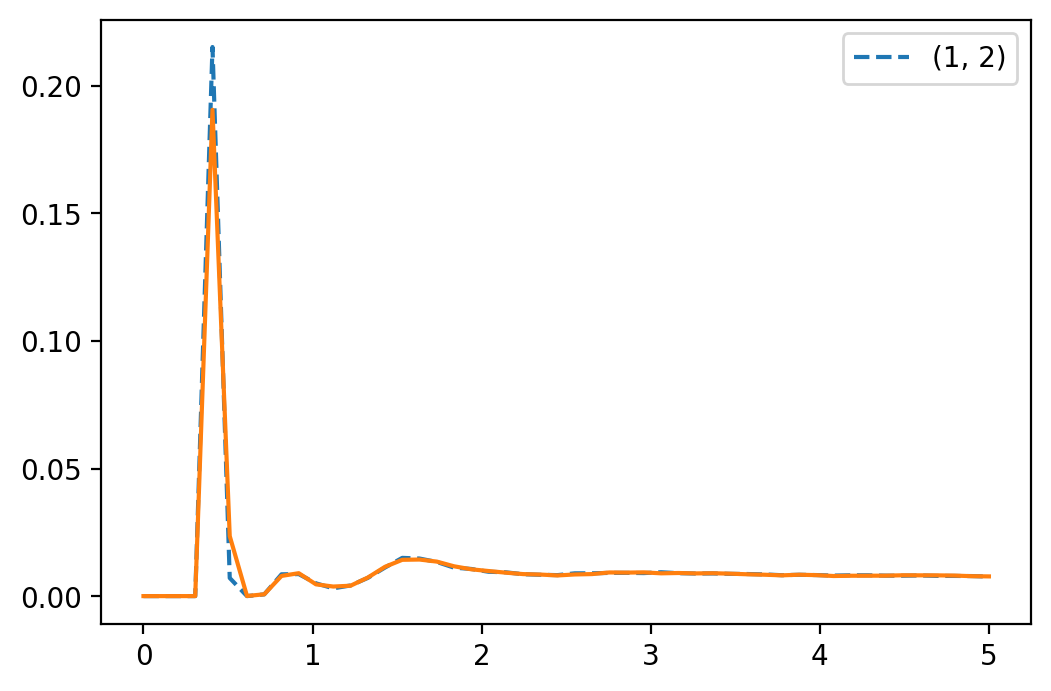

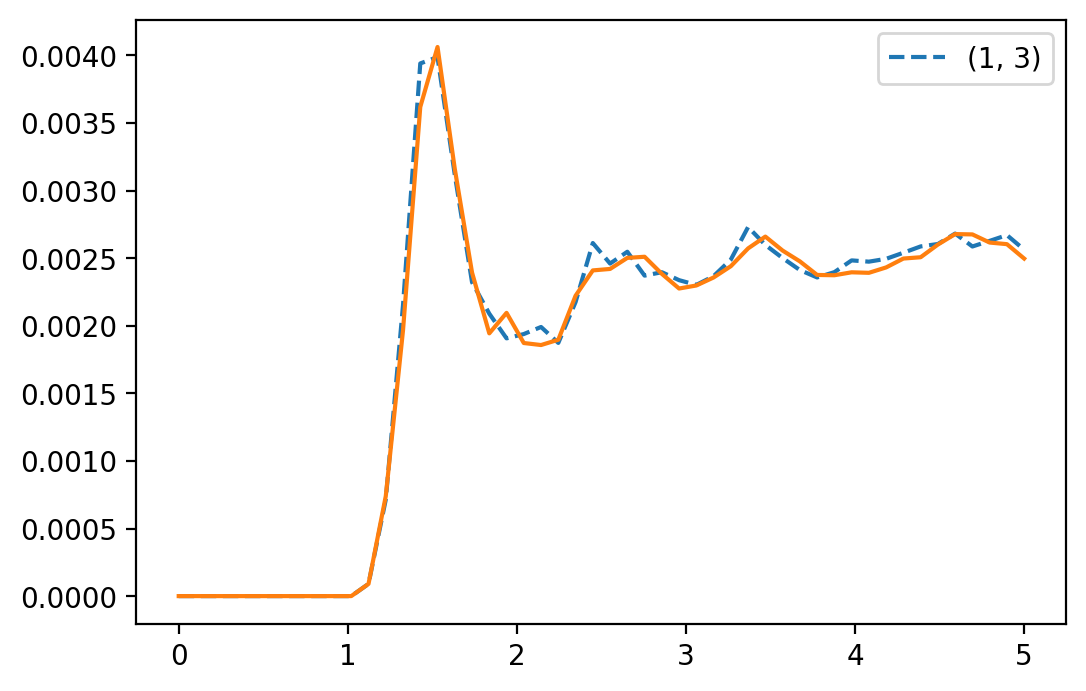

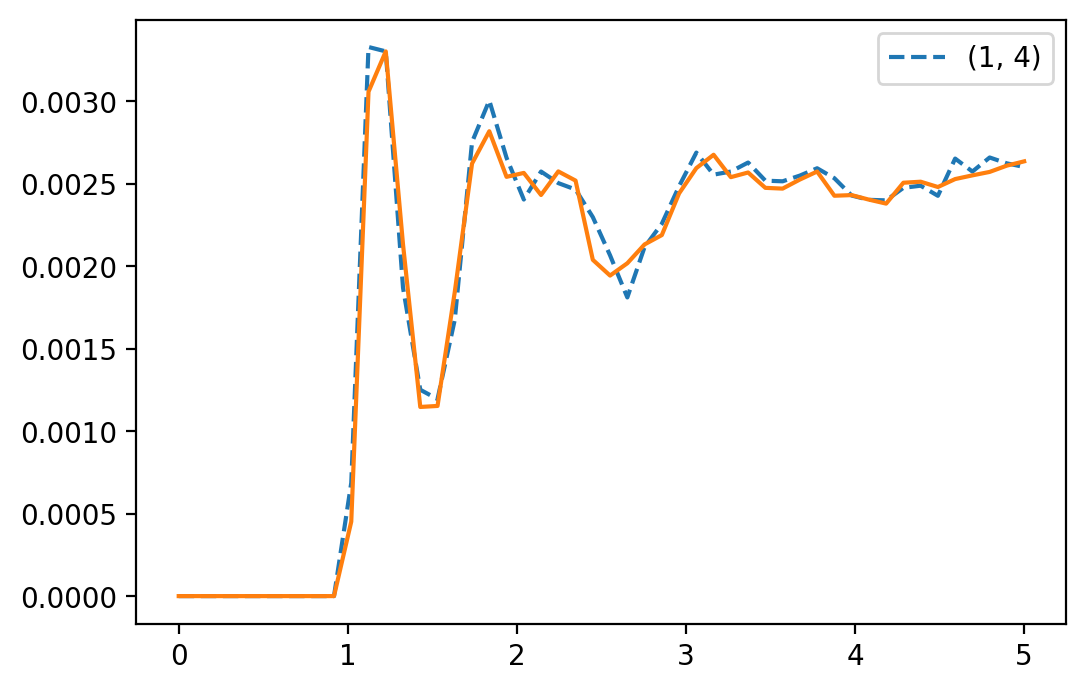

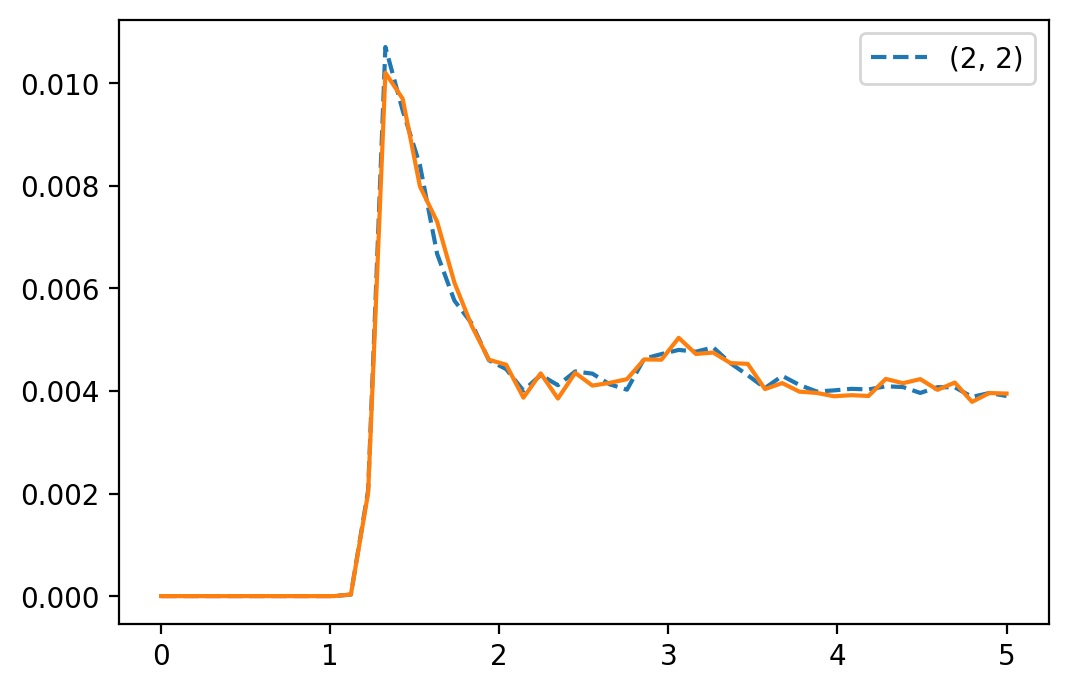

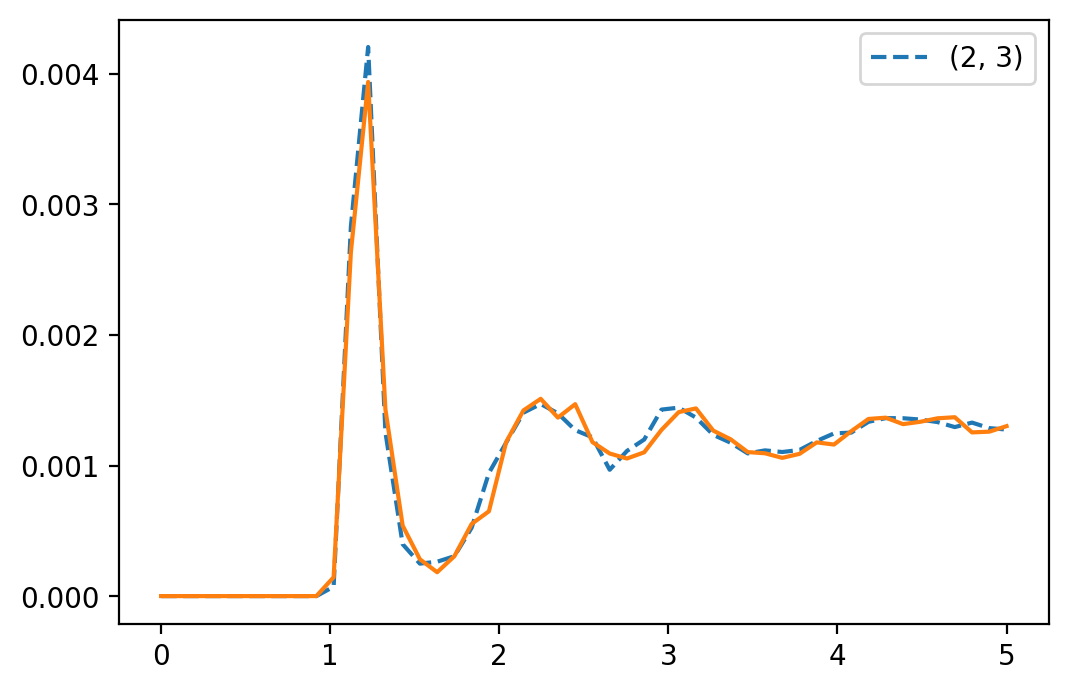

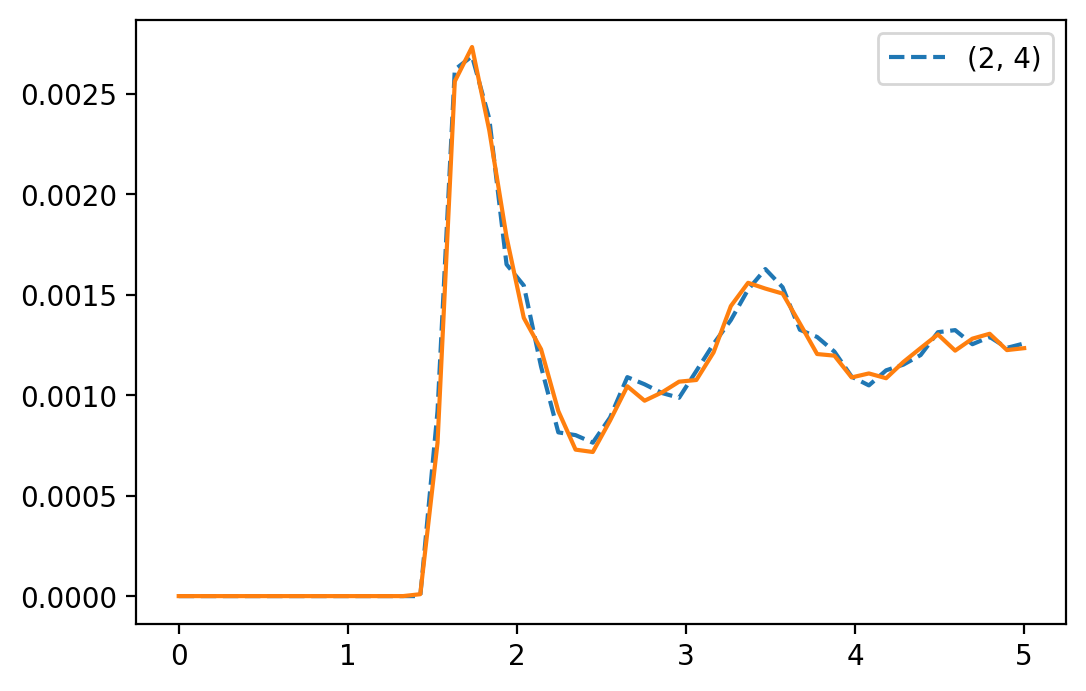

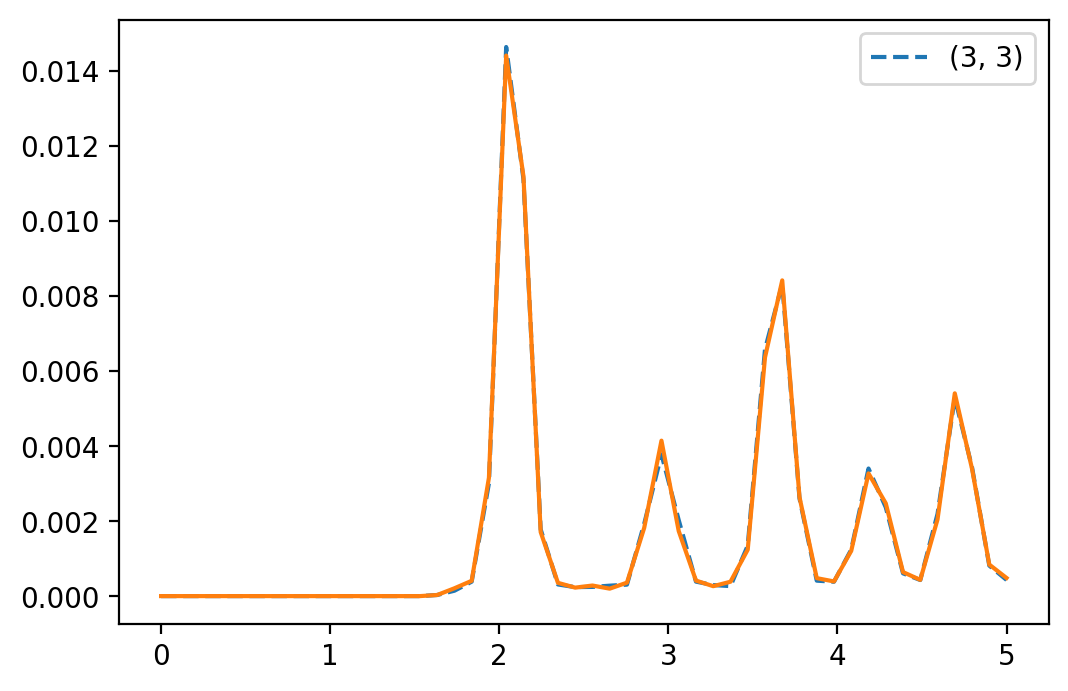

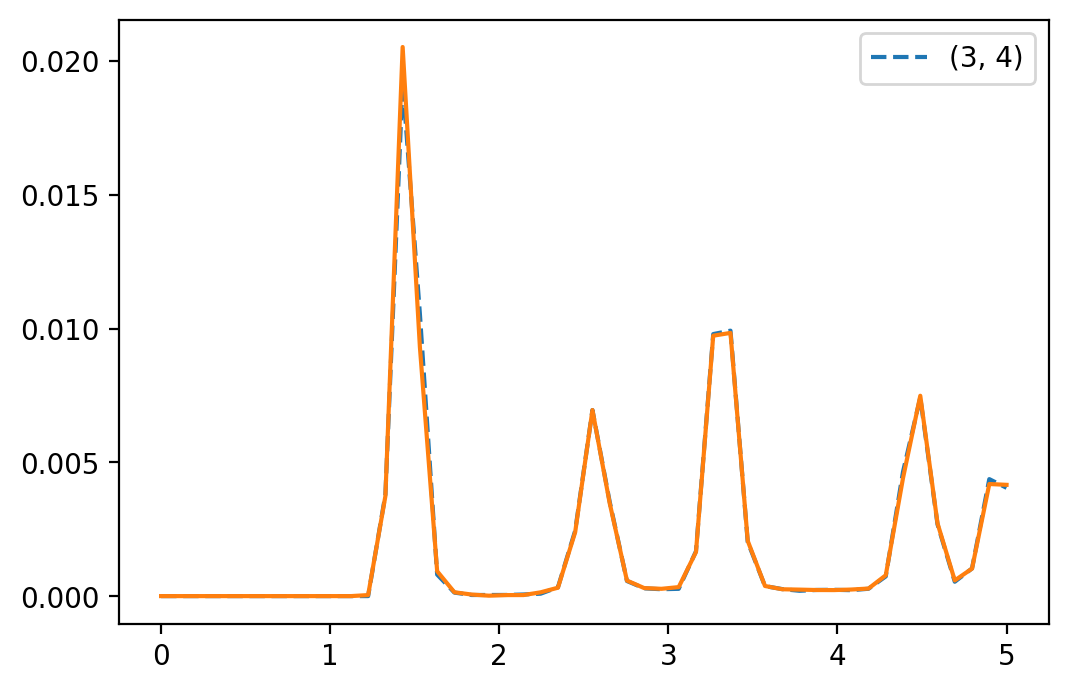

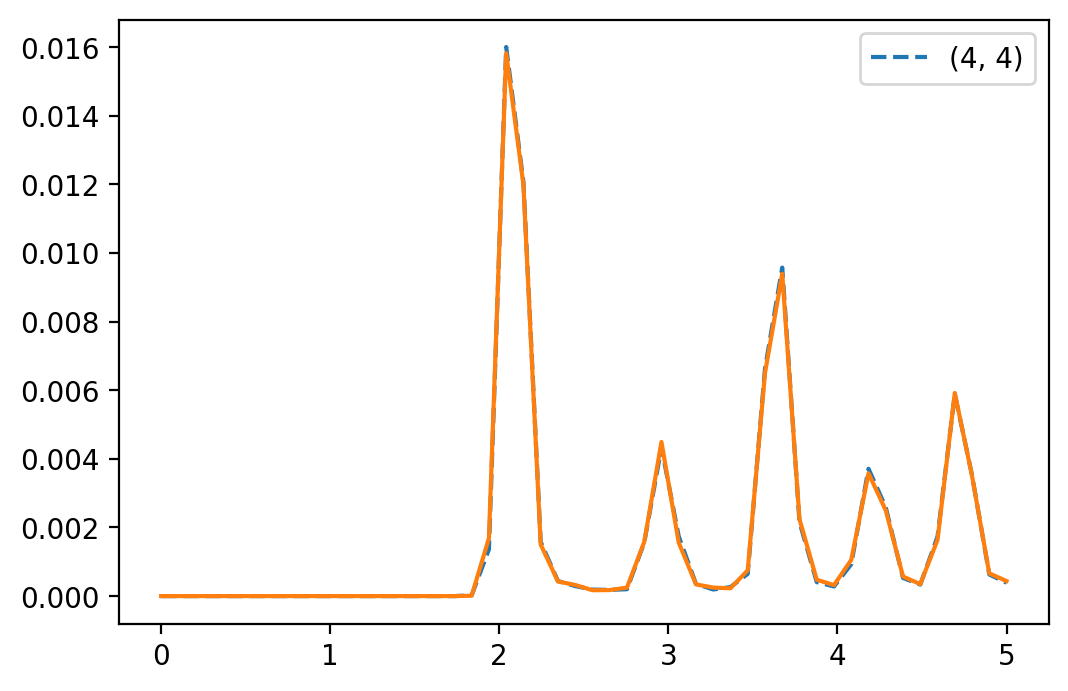

In [42]:
# i=12
frame_list = list(range(18))
error_list = []
previous_data = atom_coords[0]
# train_loss = torch.tensor([0.]).to(device)
# for i in np.arange(0,500,100):
i = 100
x_batch = feature_inputs[i:i+1]
coords_batch = atom_coords[i].to(device)
y_batch = targets[i]
model = torch.load(model_path).to(device)
y_predict = model(x_batch.to(device), coords_batch)
target_coords = coords_batch + y_batch
predicted_coords = coords_batch + y_predict
rdf1 = compute_rdf_by_unique_types(target_coords, atom_types, max_distance=10, num_bins=50, I=I, J=J, K=K)
rdf2 = compute_rdf_by_unique_types(predicted_coords[0], atom_types, max_distance=10, num_bins=50, I=I, J=J, K=K)
#     train_loss = sum([torch.abs(r1 - r2).mean() for r1, r2 in zip(rdf1.values(), rdf2.values())])

# color_figure = {(1,1):'black',
#                (1,2):'red',
#                (1,3):'blue',
#                (1,4):'green',
#                (2,2):"yellow",
#                (2,3):"orange",
#                (2,4):"purple",
#                (3,3):"pink",
#                (3,4):"brown",
#                (4,4):"cyan"}
for key in rdf1.keys():
    plt.figure()
#     plt.plot(bins, rdf1[key].cpu().detach().numpy(), '--',label = key, color = color_figure[key])
#     plt.plot(bins, rdf1[key].cpu().detach().numpy(), color = color_figure[key])
    plt.plot(bins, rdf1[key].cpu().detach().numpy(), '--',label = key)
    plt.plot(bins, rdf2[key].cpu().detach().numpy())
    plt.legend()
error_list.append(train_loss)
# plt.plot(frame_list,error_list)

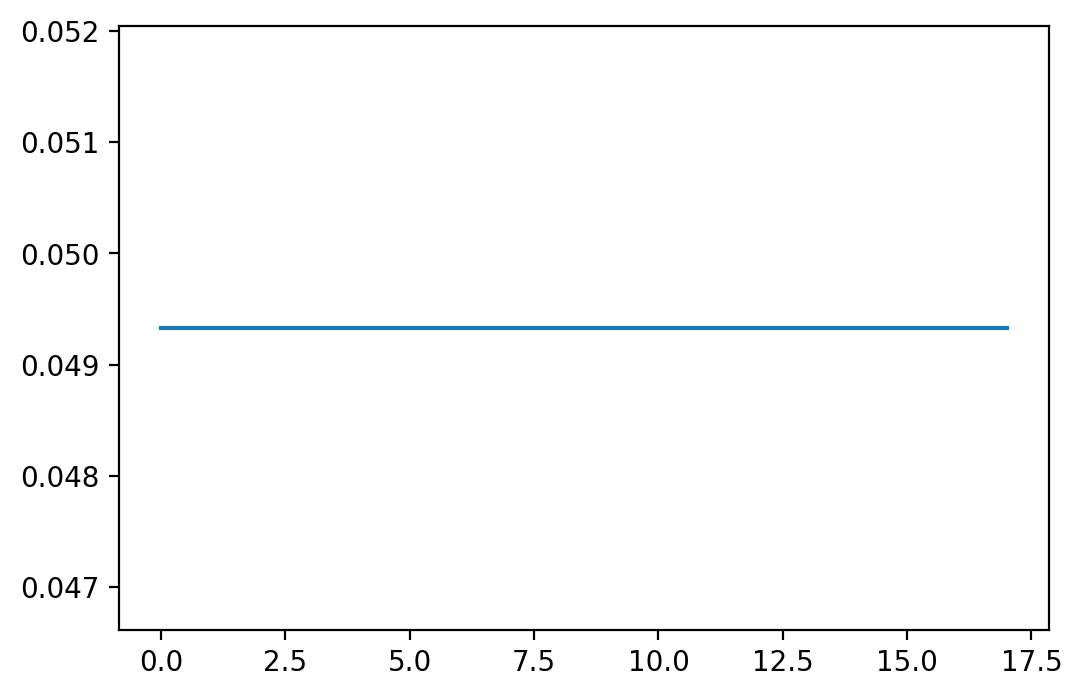

In [26]:
# i=12
frame_list = list(range(18))
error_list = []
previous_data = atom_coords[0]
# train_loss = torch.tensor([0.]).to(device)
for i in range(18):
    x_batch = feature_inputs[i:i+1]
    coords_batch = atom_coords[i].to(device)
    y_batch = targets[i]
    model = torch.load(model_path).to(device)
    y_predict = model(x_batch.to(device), coords_batch)
    target_coords = coords_batch + y_batch
    predicted_coords = coords_batch + y_predict
    rdf1 = compute_rdf_by_unique_types(target_coords, atom_types, max_distance=10, num_bins=50, I=I, J=J, K=K)
    rdf2 = compute_rdf_by_unique_types(predicted_coords[0], atom_types, max_distance=10, num_bins=50, I=I, J=J, K=K)
    train_loss = sum([torch.abs(r1 - r2).mean() for r1, r2 in zip(rdf1.values(), rdf2.values())])
    error_list.append(train_loss)
plt.plot(frame_list,error_list)

In [11]:
x = torch.linspace(0, 10, steps=50).to(device)
for key in rdf1.keys():
    y = rdf1[key]
    y2 = rdf2[key]
    plt.plot(x.cpu().detach().numpy(),y.cpu().detach().numpy(), label=key)
    plt.plot(x.cpu().detach().numpy(),y2.cpu().detach().numpy())
plt.legend()

## We may visualize the microstructures

In [12]:
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

i=7
dist_cut = 1
X = atom_coords[i][:,0].cpu().detach().numpy()
Y = atom_coords[i][:,1].cpu().detach().numpy()
Z = atom_coords[i][:,2].cpu().detach().numpy()
temp = periodic_distance(atom_coords[i+dist_cut], atom_coords[i], I, J, K)
# temp = atom_coords[i+1] - atom_coords[i]
s = torch.norm(temp - displacement[0], dim=1).cpu().detach().numpy()

# criteria =  0.2
# X = X[s>criteria]
# Y = Y[s>criteria]
# Z = Z[s>criteria]
# s = s[s>criteria]
# 查看误差多少？

# 创建图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 散点图：s值映射到颜色
img = ax.scatter(X, Y, Z, s=s, cmap=plt.hot())

# 颜色条
fig.colorbar(img)
plt.show()
